# <center>Capstone Design 2</center>
# <center>Environmental Sound Classification with CNN</center>
---

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Expand the cells width 

In [0]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Important libraries.

In [2]:
import re
import cv2
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.io import wavfile
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Activation

from __future__ import print_function
import tensorflow as tf


Using TensorFlow backend.


## Read the training dataset(Audio files)

In [3]:
audio_files = []
PATH = '/content/gdrive/My Drive/audio_6000'

for file_name in tqdm(os.listdir(PATH)):
    try:
        audio, sampling_rate = librosa.load(os.path.join(PATH,file_name),res_type='kaiser_fast')
        
        # Since class name/number is hidden in file name of audio file, so we have to extract the class name/number by regular expression.
        exp = re.findall('\d{1,2}.wav',file_name)
        audio_files.append([audio,int(float(exp[0][0:2]))])
    except Exception as e:
        pass

100%|██████████| 6000/6000 [1:00:42<00:00,  1.28it/s]


## Read and Explore the classes.

In [4]:
#Read the Classes and Categories which i alerady saved in 'classes.csv' file

df = pd.read_csv('/content/gdrive/My Drive/new_classes2.csv',delimiter = ',') ## header of classes.

categories = df.columns.tolist()

classes =      list(df[categories[0]].values)
classes.extend(list(df[categories[1]].values))
classes.extend(list(df[categories[2]].values))
classes.extend(list(df[categories[3]].values))
classes.extend(list(df[categories[4]].values))
df

,NaturePlace,LoudPlace,MusicPlace,QuietPlace,EtcPlace
0,Mountain,Factory,MusicConcert,Home,Road
1,Sea,Airport,ClassicConcert,Office,LectureRoom
2,Cave,Harbor,Club,Library,Caf?


## Explore a random training example
<b>sampling_rate - </b> which keep the flow of number of element per second of audio files

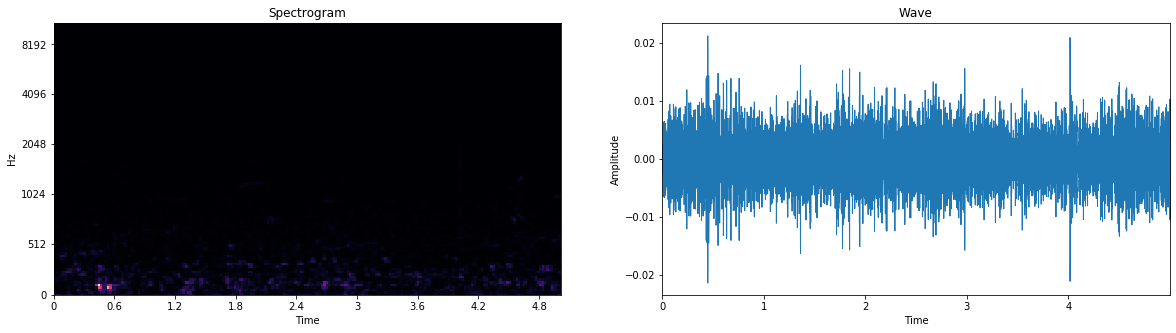

CLASS: MusicPlace
SUBCLASS: ClassicConcert


In [5]:
number_of_training_example = len(audio_files)

# One random index
random_index = np.random.randint(0,number_of_training_example)

plt.figure(figsize=(20,5))
plt.subplot(121)

audio, _class = audio_files[random_index][0],audio_files[random_index][1]

# Convert audio into spectrogram
spectrogram = librosa.feature.melspectrogram(audio)
plt.title("Spectrogram")
librosa.display.specshow(spectrogram, y_axis='mel', x_axis='time')

# Convert into wave form 
sampling_rate = int(len(audio)/5)
plt.subplot(122)
plt.title("Wave")
librosa.display.waveplot(audio, sr=sampling_rate)
plt.ylabel('Amplitude')
plt.show()

print('CLASS:',categories[int(_class/3)])
print('SUBCLASS:',classes[_class])

#Audio
Audio(audio,rate = sampling_rate)

In [0]:
audio_files= np.array(audio_files)

X = list(audio_files[:,0])

Y = audio_files[:,1]

del audio_files

## Augmentation<br>

<li><b> Data augmentation</b> is a technique to artificially create new training data from existing training data.</li>
<li> Since available dataset is not sufficient to train the model so i added the <b>white noise</b> to existing dataset.</li>
<li>Now we have 4000 training example.</li>

In [0]:
# It will take few seconds for augmentation.
size_of_audio_files = len(X[0])

number_of_audio_files = len(Y)

augmented_audio_files = []

for i in range(number_of_audio_files): 
    
    # Adding white noise
    X.append(X[i] + 0.005*np.random.randn(size_of_audio_files))
    
Y = np.r_[Y,Y]

## Split  dataset into training and testing

In [0]:
train_x,test_x,train_y,test_y = train_test_split(X, Y, test_size = 0.1, random_state=5, shuffle = True)


## Convert the input data into spectrogram to train the model

In [0]:
# It will take few seconds to covert audio into Spectrogram_files
x = train_x
train_x = []
length = len(train_y)

for i in range(length):
    train_x.append(librosa.feature.melspectrogram(x[i], sampling_rate))
del x    

In [10]:
# get the input diamention
SPEC_H, SPEC_W = train_x[0].shape
train_x = np.reshape(train_x,(length,SPEC_H, SPEC_W,1))
print(train_x.shape)

(10800, 128, 216, 1)


## Create Compile and Train the model

In [11]:
# create the model

model = Sequential()

# add layers
model.add(Conv2D(64, kernel_size=3, activation="relu", input_shape=(SPEC_H, SPEC_W, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=3, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, kernel_size=3, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, kernel_size=3, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(15, activation="softmax"))


# compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Training and Evaluation of the model
hist = model.fit(train_x, train_y, batch_size = 30 ,epochs=30,validation_split=0.1)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 9720 samples, validate on 1080 samples
Epoch 1/30





9720/9720 [==============================] - 21s 2ms/step - loss: 2.0646 - acc: 0.3193 - val_loss: 1.4822 - val_acc: 0.4898
Epoch 2/30
9720/9720 [==============================] - 12s 1ms/step - loss: 1.3541 - acc: 0.5288 - val_loss: 0.9339 - val_acc: 0.6917
Epoch 3/30
9720/9720 [==============================] - 12s 1ms/step - loss: 0.9012 - acc: 0.6787 - val_loss: 0.5657 - val_acc: 0.8176
Epoch 4/30
9720/9720 [==============================] - 12s 1ms/step - loss: 0.6827 - acc: 0.7544 - val_loss: 0.4702 - val_acc: 0.8222
Epoch 5/30
9720/9720 [==============================] - 12s 1ms/step - loss: 0.5648 - acc: 0.8050 - val_loss: 0.5074 - val_acc: 0.8519
Epoch 6/30
9720/9720 [==============================]

10800/10800 [==============================] - 5s 434us/step


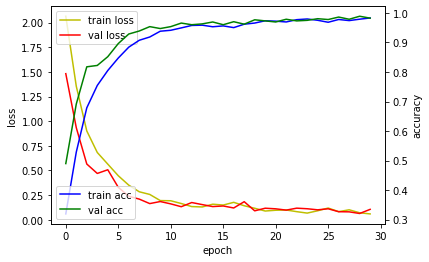

Change the model change dense layer(128) plus dropout layer(0.5)
epoch: 10, sampling rate =44100, sample label 15, total sample = 12000
Test Accuracy 0.9708
Train Accuracy 0.9944


In [12]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

t_x = test_x

test_x = []
length = len(test_y)

for i in range(length):
    test_x.append(librosa.feature.melspectrogram(t_x[i], sampling_rate))
del t_x    
test_x = np.reshape(test_x,(length,SPEC_H, SPEC_W,1))
test_result = model.evaluate(test_x, test_y)
train_result = model.evaluate(train_x, train_y)
plt.show()
print("Change the model change dense layer(128) plus dropout layer(0.5)")
print("epoch: 10, sampling rate =44100, sample label 15, total sample = 12000")
print("Test Accuracy",round(test_result[1],4))
print("Train Accuracy",round(train_result[1],4))

model.save("/content/gdrive/My Drive/train_label15_6000_final.h5")

In [0]:
from keras.models import load_model
model2 = load_model('/content/gdrive/My Drive/train_label15_6000_final.h5')
t_x1 = test_x

test_x = []
length = len(test_y)

for i in range(length):
    
    test_x.append(librosa.feature.melspectrogram(t_x1[i], sampling_rate))
#del t_x1    
test_x = np.reshape(test_x,(length,SPEC_H, SPEC_W,1))
test_result = model2.evaluate(test_x, test_y)
train_result = model2.evaluate(train_x, train_y)


print("Test Accuracy",round(test_result[1],4))
print("Train Accuracy",round(train_result[1],4))

In [0]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 126, 214, 64)      640       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 63, 107, 64)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 61, 105, 128)      73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 30, 52, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 50, 256)       295168    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 25, 256)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 12, 23, 256)      